#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


#Load Datasets

In [ ]:
def load_dataframe(subset_number):
    turbo_train= pd.read_csv(f"/content/drive/MyDrive/NASAturbofan/train_FD00{subset_number}.txt", sep='\s+',header=None, index_col=False)
    turbo_test = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/test_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    y_RUL = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/RUL_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    return turbo_train, turbo_test, y_RUL


In [ ]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [ ]:
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [ ]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [ ]:
nr_test_2

259

In [ ]:
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [ ]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [ ]:
turbofan1

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'Epr', 'Ps30', 'Phi',
                 'NRf', 'Nrc', 'BPR', 'farB', 'htBleed', 'NF-dmd', 'PCNR-dmd', 'W31', 'W32']
  turbofan.columns = new_columns
  return turbofan

In [ ]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [ ]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,Phi,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


#Exploratory Data Analysis 1

##Univariate

In [ ]:
def get_info(turbofan):
   return turbofan.info()

In [ ]:
info1=get_info(turbofan1)
info2=get_info(turbofan2)
info3=get_info(turbofan3)
info4=get_info(turbofan4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33727 entries, 0 to 33726
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ENr       33727 non-null  int64  
 1   C         33727 non-null  int64  
 2   OP-1      33727 non-null  float64
 3   OP-2      33727 non-null  float64
 4   OP-3      33727 non-null  float64
 5   T2        33727 non-null  float64
 6   T24       33727 non-null  float64
 7   T30       33727 non-null  float64
 8   T50       33727 non-null  float64
 9   P2        33727 non-null  float64
 10  P15       33727 non-null  float64
 11  P30       33727 non-null  float64
 12  Nf        33727 non-null  float64
 13  Nc        33727 non-null  float64
 14  Epr       33727 non-null  float64
 15  Ps30      33727 non-null  float64
 16  Phi       33727 non-null  float64
 17  NRf       33727 non-null  float64
 18  Nrc       33727 non-null  float64
 19  BPR       33727 non-null  float64
 20  farB      33727 non-null  fl

In [ ]:
def check_missing(turbofan):
   return turbofan.isnull().sum()

In [ ]:
missing1=check_missing(turbofan1)
missing2=check_missing(turbofan2)
missing3=check_missing(turbofan3)
missing4=check_missing(turbofan4)

In [ ]:
missing4

ENr         0
C           0
OP-1        0
OP-2        0
OP-3        0
T2          0
T24         0
T30         0
T50         0
P2          0
P15         0
P30         0
Nf          0
Nc          0
Epr         0
Ps30        0
Phi         0
NRf         0
Nrc         0
BPR         0
farB        0
htBleed     0
NF-dmd      0
PCNR-dmd    0
W31         0
W32         0
dtype: int64

In [ ]:
def unique_values(turbofan):
   return turbofan.nunique()

In [ ]:
unique1=unique_values(turbofan1)
unique2=unique_values(turbofan2)
unique3=unique_values(turbofan3)
unique4=unique_values(turbofan4)

In [ ]:
unique3

ENr          200
C            525
OP-1         163
OP-2          14
OP-3           1
T2             1
T24          344
T30         3521
T50         4548
P2             1
P15           17
P30         1882
Nf           167
Nc          7725
Epr            4
Ps30         175
Phi         1796
NRf          169
Nrc         6767
BPR         3152
farB           1
htBleed       13
NF-dmd         1
PCNR-dmd       1
W31          165
W32         6698
dtype: int64

NOTE: Here we can see the columns with constant columns and the attributes dependent on the number of conditions

In [ ]:
def statistics(turbofan):
  description=turbofan.describe()
  skewness = turbofan.apply(skew)
  kurt = turbofan.apply(kurtosis)
  statistics = turbofan.describe()
  statistics.loc['skewness'] = skewness
  statistics.loc['kurtosis'] = kurt
  return statistics

In [ ]:
stat1=statistics(turbofan1)
stat2=statistics(turbofan2)
stat3=statistics(turbofan3)
stat4=statistics(turbofan4)

In [ ]:
stat4

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,Phi,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32
count,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,...,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000
mean,222.743888,124.025385,24.046234,0.572705,94.048193,472.813726,579.278956,1416.712022,1200.067378,8.020251,...,266.204160,2334.550571,8065.959530,9.285226,0.023163,347.444795,2228.592009,97.757657,20.837898,12.503177
std,139.858594,88.288695,14.754162,0.309970,14.235528,26.390489,37.257343,105.878109,118.898635,3.614543,...,138.077777,128.048614,85.082502,0.747948,0.004650,27.729173,145.229217,5.363235,9.913949,5.949074
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.420000,1240.940000,1024.420000,3.910000,...,128.260000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,105.000000,53.000000,10.004700,0.250700,100.000000,445.000000,549.280000,1349.630000,1118.215000,3.910000,...,134.240000,2387.900000,8061.910000,8.642800,0.020000,330.000000,2212.000000,100.000000,10.920000,6.556200
50%,207.000000,109.000000,25.001500,0.700000,100.000000,462.540000,555.650000,1366.530000,1134.410000,7.050000,...,183.420000,2388.050000,8082.160000,9.257800,0.020000,334.000000,2223.000000,100.000000,14.930000,8.959500
75%,337.000000,178.000000,41.998100,0.840000,100.000000,491.190000,607.000000,1496.340000,1301.105000,10.520000,...,371.420000,2388.140000,8127.400000,9.360000,0.030000,368.000000,2324.000000,100.000000,28.570000,17.141100
max,497.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,...,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200
skewness,0.252763,0.839890,-0.263635,-0.837642,-1.973690,0.460900,0.446200,0.171387,0.434660,0.540747,...,0.704658,-1.973683,-1.431087,1.040210,0.790250,0.187423,-1.222332,-1.973690,0.646536,0.646602
kurtosis,-1.060634,0.450028,-1.225285,-0.862945,1.895453,-1.176437,-1.305780,-1.129782,-1.100341,-0.845939,...,-0.866691,1.895443,0.935574,0.367035,-1.375504,-1.128358,0.501914,1.895453,-0.931173,-0.930748


NOTE: The warning is generated when calculating skewness and kurtosis for the constant attributes (because division is made with 0)

In [ ]:
def boxplots(turbofan):
  for x in turbofan.columns:
      plt.figure(figsize=(7,5))
      plt.boxplot(turbofan1[x])
      plt.title(x)
      plt.show()

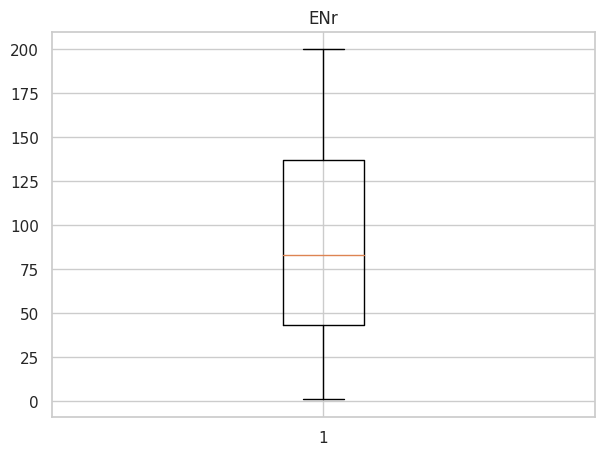

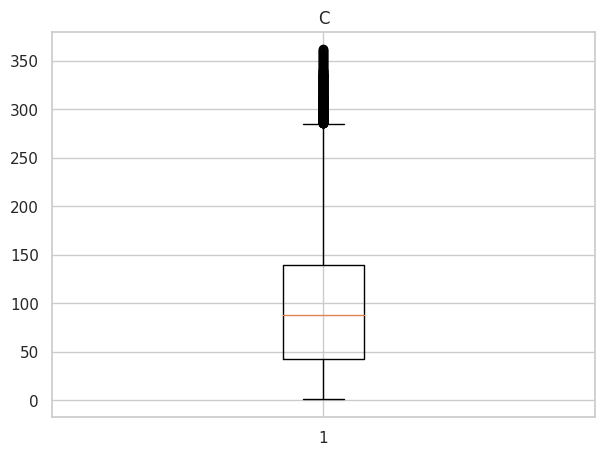

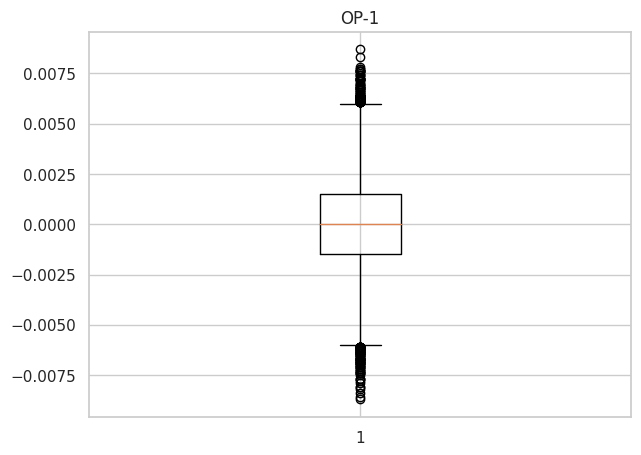

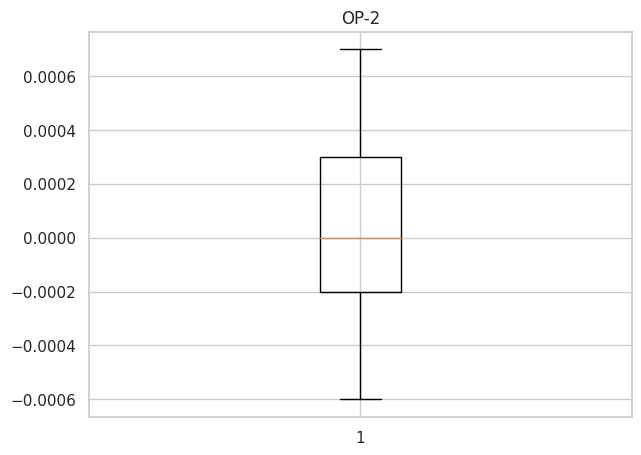

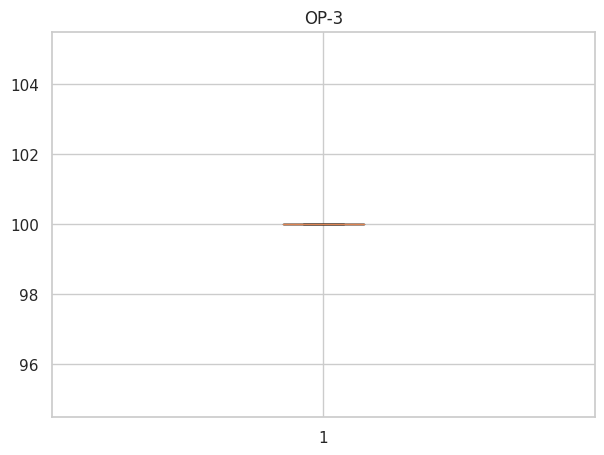

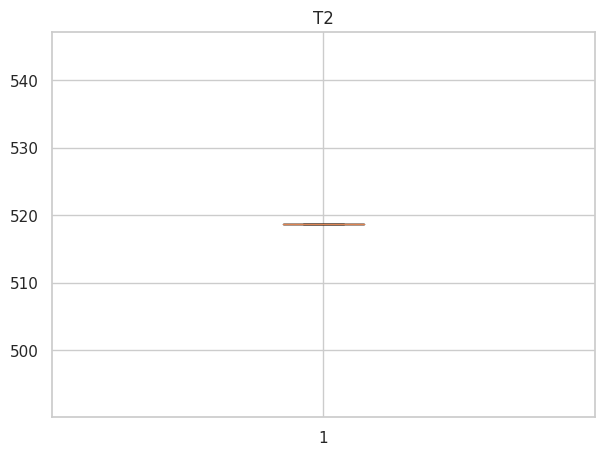

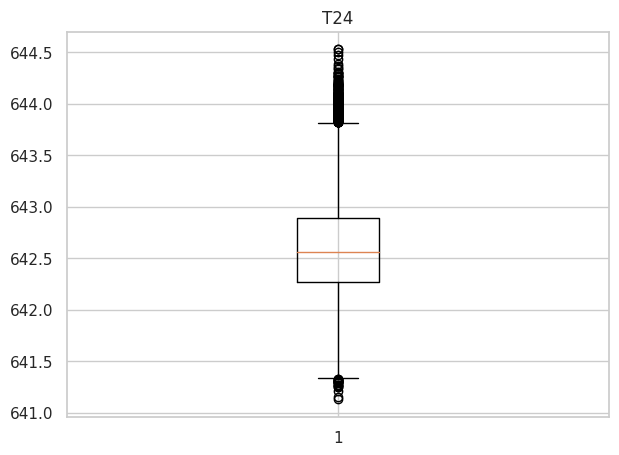

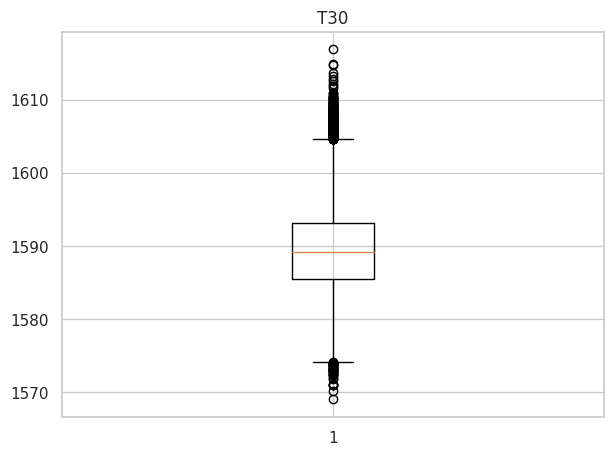

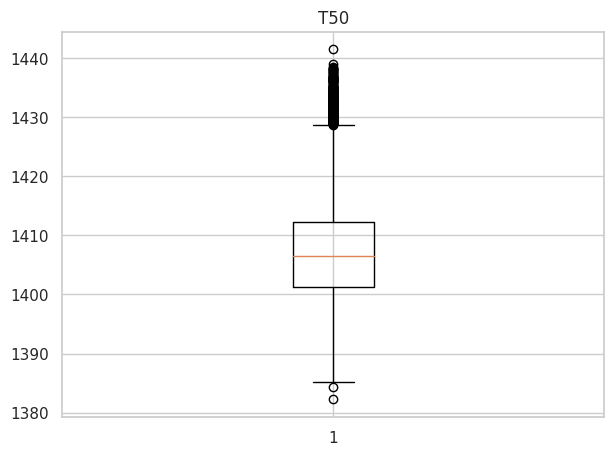

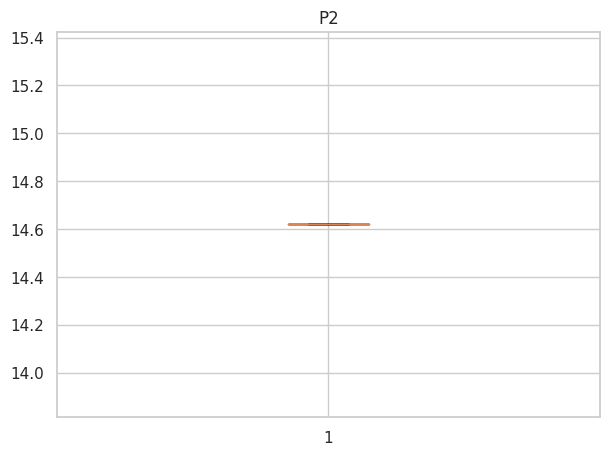

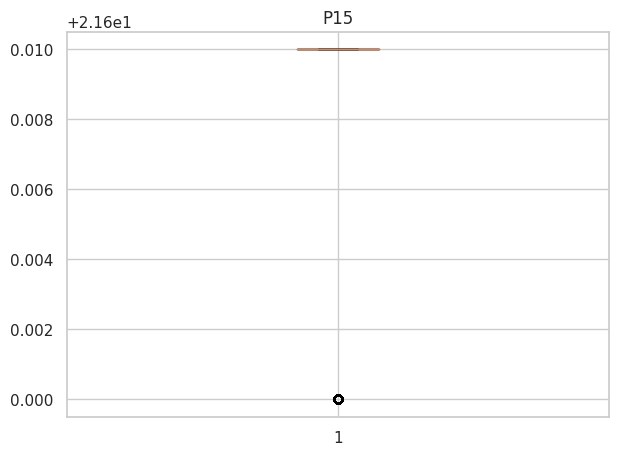

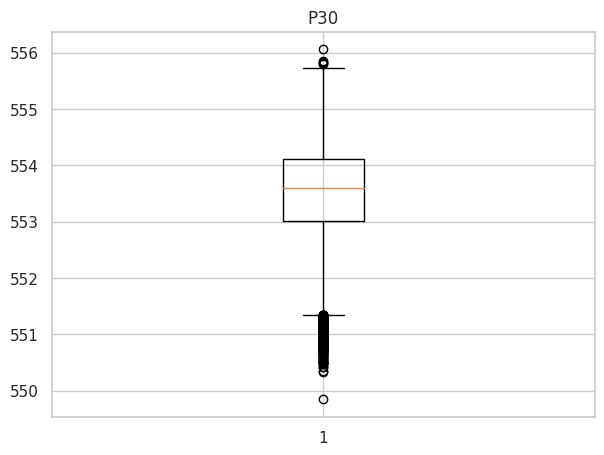

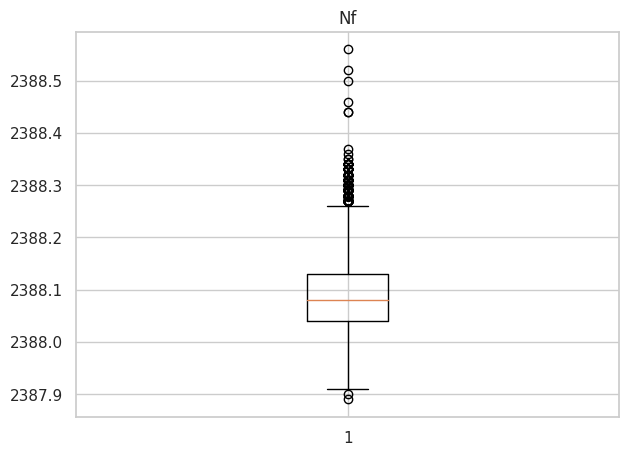

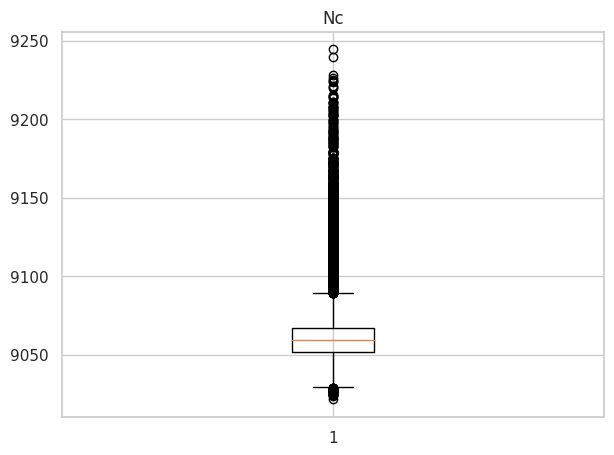

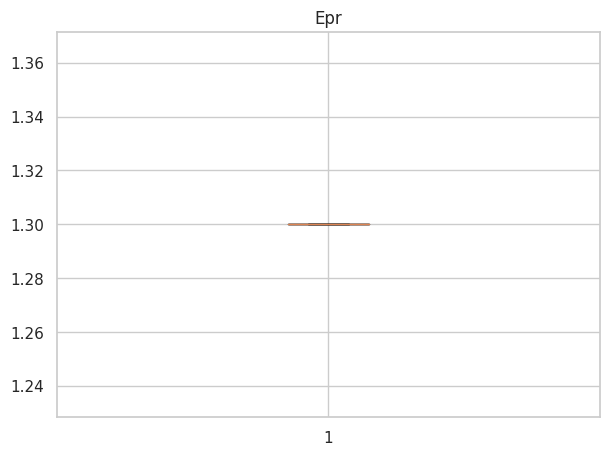

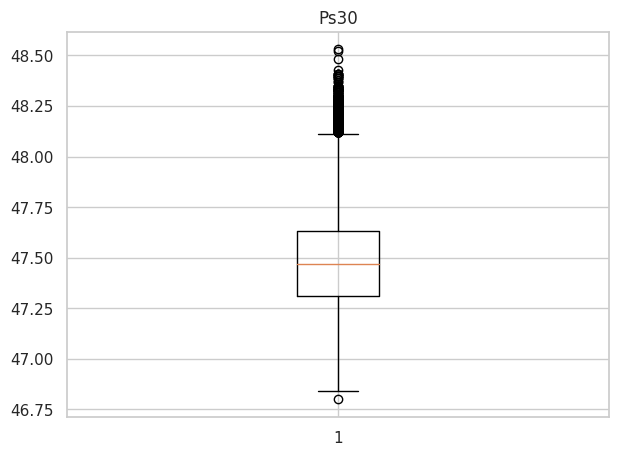

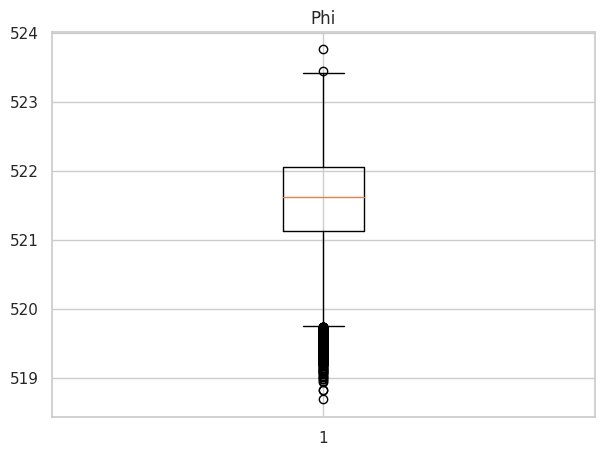

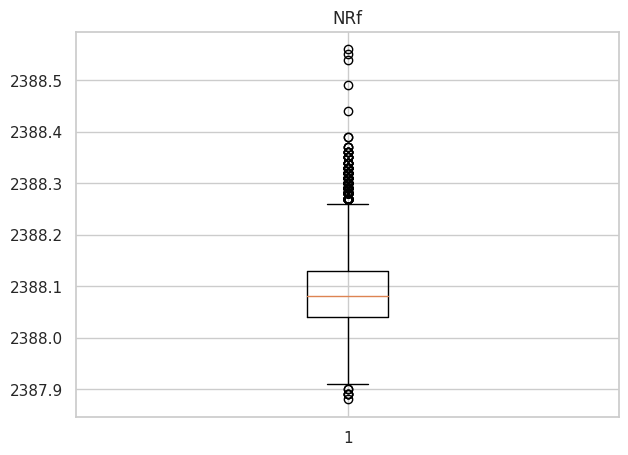

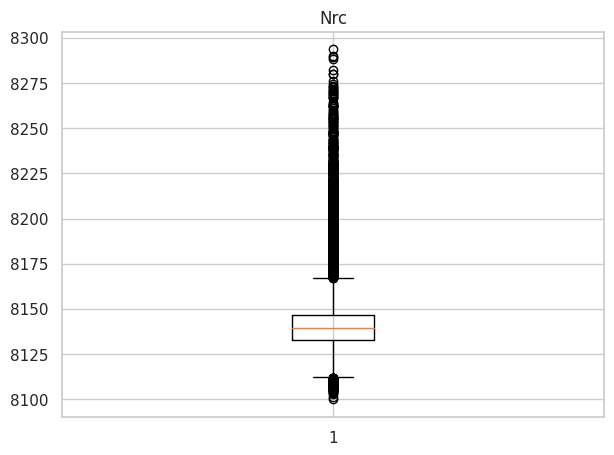

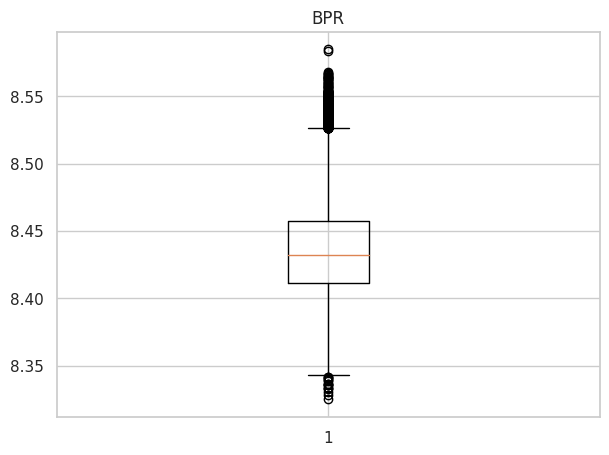

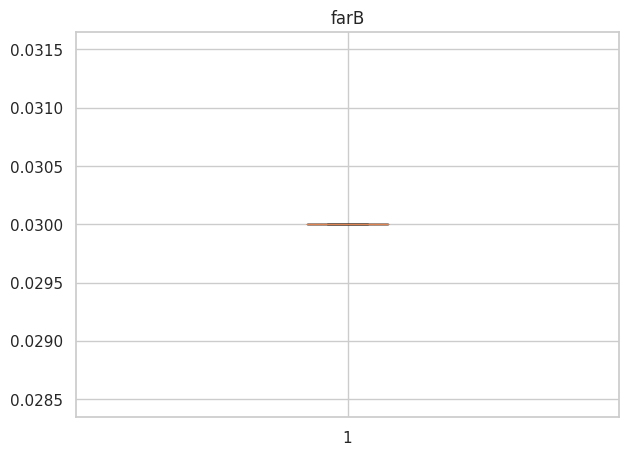

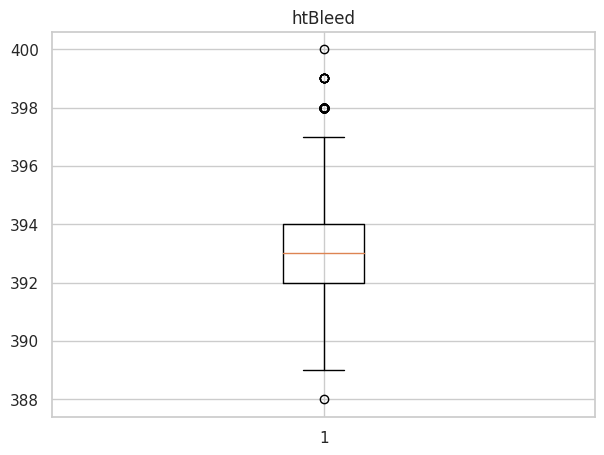

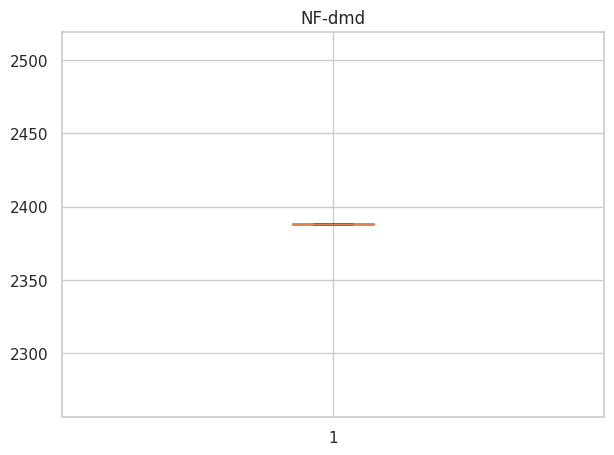

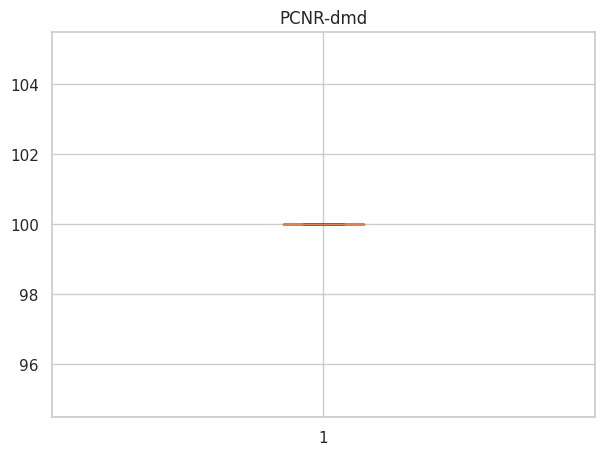

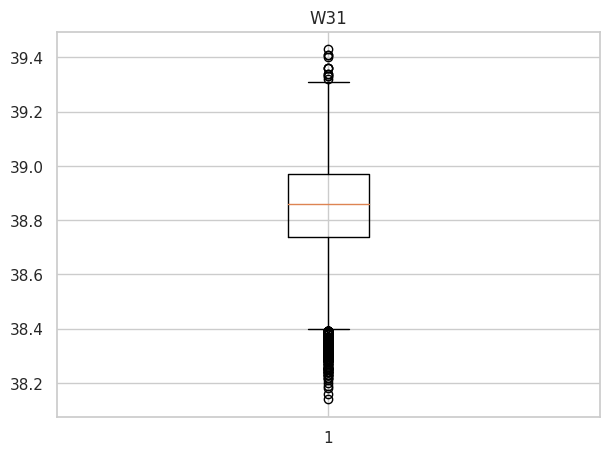

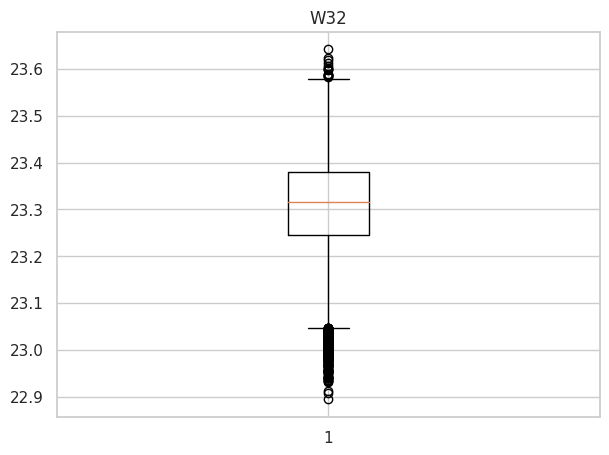

In [ ]:
boxplots(turbofan4)

BOXPLOT CONCLUSION: There are a lot of outliers

#Preprocessing

##Filtering

In [ ]:
def moving_median(turbofan, window_size, period):
    columns_to_filter = turbofan.columns.drop(['ENr', 'C', 'OP-1', 'OP-2', 'OP-3'])
    filtered_turbo = turbofan.copy()
    filtered_turbo[columns_to_filter] = turbofan[columns_to_filter].rolling(window=window_size, min_periods=period, axis=0).median()
    return filtered_turbo

In [ ]:
filtered_turbo1=moving_median(turbofan1, 5, 1)
filtered_turbo2=moving_median(turbofan2, 5, 1)
filtered_turbo3=moving_median(turbofan3, 5, 1)
filtered_turbo4=moving_median(turbofan4, 5, 1)

In [ ]:
filtered_turbo1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,Phi,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.820,1589.700,1400.600,14.62,...,521.66,2388.020,8138.620,8.41950,0.03,392.0,2388.0,100.0,39.060,23.41900
1,1,2,0.0019,-0.0003,100.0,518.67,641.985,1590.760,1401.870,14.62,...,521.97,2388.045,8135.055,8.42565,0.03,392.0,2388.0,100.0,39.030,23.42130
2,1,3,-0.0043,0.0003,100.0,518.67,642.150,1589.700,1403.140,14.62,...,522.28,2388.030,8133.230,8.41950,0.03,392.0,2388.0,100.0,39.000,23.41900
3,1,4,0.0007,0.0000,100.0,518.67,642.250,1588.845,1402.505,14.62,...,522.35,2388.050,8133.530,8.41865,0.03,392.0,2388.0,100.0,38.975,23.39645
4,1,5,-0.0019,-0.0002,100.0,518.67,642.350,1587.990,1403.140,14.62,...,522.28,2388.040,8133.800,8.41950,0.03,392.0,2388.0,100.0,38.950,23.40440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.050,1598.180,1415.790,14.62,...,521.23,2388.070,8210.240,8.47150,0.03,395.0,2388.0,100.0,38.740,23.22790
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.100,1595.690,1415.790,14.62,...,521.05,2388.070,8210.850,8.45120,0.03,395.0,2388.0,100.0,38.650,23.22790
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.220,1595.690,1415.790,14.62,...,521.05,2388.050,8213.280,8.45120,0.03,395.0,2388.0,100.0,38.630,23.21480
33725,200,197,-0.0038,0.0001,100.0,518.67,643.240,1595.600,1415.790,14.62,...,521.18,2388.050,8213.570,8.45690,0.03,395.0,2388.0,100.0,38.630,23.26990


##Data Normalization

In [ ]:
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [ ]:
normalized_turbo1=z_score(turbofan1)
normalized_turbo2=z_score(turbofan2)
normalized_turbo3=z_score(turbofan3)
normalized_turbo4=z_score(turbofan4)

In [ ]:
normalized_turbo1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,Phi,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32
0,1,1,-0.314711,-1.373690,0.0,0.0,-1.644975,0.020217,-0.794964,-3.552714e-15,...,0.168348,-0.981906,-0.199424,-0.461431,-1.387779e-17,-0.655669,0.0,0.0,1.254019,1.091572
1,1,2,0.870755,-1.032895,0.0,0.0,-0.949920,0.383216,-0.493750,-3.552714e-15,...,1.062424,-0.242468,-0.634651,-0.113571,-1.387779e-17,-0.655669,0.0,0.0,0.902637,1.136638
2,1,3,-1.956125,1.011877,0.0,0.0,-0.528674,-0.272579,-0.368046,-3.552714e-15,...,1.264312,-0.834018,-0.528438,-0.509509,-1.387779e-17,-2.018065,0.0,0.0,0.609819,0.358754
3,1,4,0.323617,-0.010509,0.0,0.0,-0.528674,-1.162954,-0.644357,-3.552714e-15,...,1.898818,-0.094581,-0.491813,-1.912263,-1.387779e-17,-0.655669,0.0,0.0,0.199874,0.649726
4,1,5,-0.861849,-0.692099,0.0,0.0,-0.486549,-1.152680,-0.128498,-3.552714e-15,...,0.932638,-0.686131,-0.493645,-0.181446,-1.387779e-17,0.025530,0.0,0.0,0.317001,0.948535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,2.238601,-0.010509,0.0,0.0,1.345871,1.689670,1.006393,-3.552714e-15,...,-1.230449,-1.277681,4.357951,1.009197,-1.387779e-17,0.706728,0.0,0.0,-1.147090,-1.079451
33723,200,195,-0.497090,-0.351304,0.0,0.0,1.303746,1.045861,1.748756,-3.552714e-15,...,-0.711308,0.053306,4.209620,0.435087,-1.387779e-17,1.387926,0.0,0.0,-1.615598,-0.298627
33724,200,196,-0.269116,-1.032895,0.0,0.0,1.767116,0.610947,-0.057345,-3.552714e-15,...,-0.523840,-0.686131,4.599676,0.596290,-1.387779e-17,1.387926,0.0,0.0,-1.322780,-1.004014
33725,200,197,-1.728151,0.330287,0.0,0.0,1.387995,0.926002,1.429753,-3.552714e-15,...,-0.307532,-0.094581,4.797451,0.997885,-1.387779e-17,1.387926,0.0,0.0,-1.088526,-0.369166


##Degradation modeling

In [ ]:
#for one engine
engine_sensors = normalized_turbo1[normalized_turbo1['ENr'] == 56]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'OP-1', 'OP-2', 'OP-3'])
engine_values=eng_sens.values

N = len(engine_sensors)
window_length = 10
Th=0.001
g=N/window_length
centroids=[]
mean_centroids=[]
sq=[]
iruls=[]


windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

for window in windows:
  centroid=window.mean()
  centroids.append(centroid)
  mean_centroid=centroid.mean()
  mean_centroids.append(mean_centroid)

for i in range(len(windows)-1):
  s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
  squared=s**2
  sq.append(squared)
  if squared>=Th:
    irul=N-window_length*i
    iruls.append(irul)
  else:
    i=i+1

print(max(iruls))

205


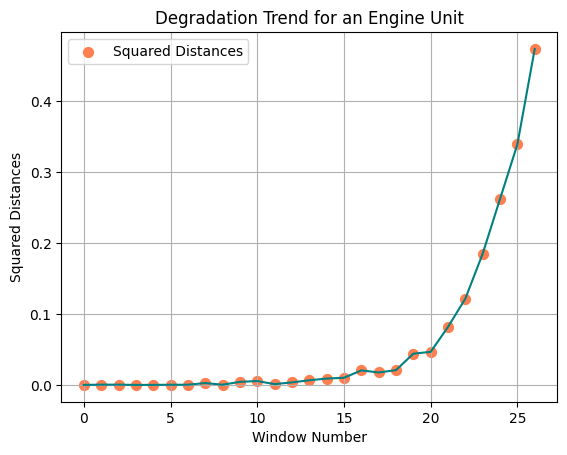

In [ ]:
plt.scatter(range(len(sq)), sq, color='coral', label='Squared Distances', s=50)
plt.xlabel('Window Number')
plt.ylabel('Squared Distances')
plt.title('Degradation Trend for an Engine Unit')
plt.legend()
plt.grid(True)


plt.plot(range(len(sq)), sq, color='teal', linestyle='-')

In [ ]:
def degradation_model(normalized_turbo, nr_eng, window_length, Th):
  RULs=[]
  RUL=0
  for i in range (1, nr_eng):
    engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
    eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'OP-1', 'OP-2', 'OP-3'])
    engine_values=eng_sens.values

    N = len(engine_sensors)
    g=N/window_length
    centroids=[]
    mean_centroids=[]
    sq=[]
    iruls=[]


    windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

    for window in windows:
      centroid=window.mean()
      centroids.append(centroid)
      mean_centroid=centroid.mean()
      mean_centroids.append(mean_centroid)

    for i in range(len(windows)-1):
      s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
      squared=s**2
      sq.append(squared)
      if squared>=Th:
        irul=N-window_length*i
        iruls.append(irul)
      else:
        i=i+1

    RUL=max(iruls)
    RULs.append(RUL)
  final_RUL=min(RULs)
  return final_RUL


In [ ]:
initial_RUL1=degradation_model(normalized_turbo1, nr_train_1, 5, 0.01)
initial_RUL2=degradation_model(normalized_turbo2, nr_train_2, 5, 0.01)
initial_RUL3=degradation_model(normalized_turbo3, nr_train_3, 5, 0.01)
initial_RUL4=degradation_model(normalized_turbo4, nr_train_4, 5, 0.01)

In [ ]:
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=5, th=0.01) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=5, th=0.01) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL4)

Minimum initial (w=5, th=0.01) RUL for FD001: 42
Minimum initial (w=5, th=0.01) RUL for FD002: 119
Minimum initial (w=5, th=0.01) RUL for FD003: 55
Minimum initial (w=5, th=0.01) RUL for FD001: 119


#Assigning RUL labels

In [ ]:
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [ ]:
turbo1_RUL_train, turbo1_RUL_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_RUL_train, turbo2_RUL_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_RUL_train, turbo3_RUL_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_RUL_train, turbo4_RUL_test=split_dataframe(normalized_turbo4, nr_train_4)

In [ ]:
turbo2_RUL_test

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,Phi,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32
53759,261,1,-0.947915,-1.035804,0.417857,0.610727,0.680517,0.733717,0.843531,0.686986,...,0.765100,0.418515,0.575995,-0.903523,1.439723,0.750597,0.620197,0.417857,0.770033,0.787435
53760,261,2,-0.270119,0.413325,0.417857,0.691743,0.755300,0.583000,0.349136,0.363574,...,0.356120,0.418046,-0.146715,-0.111609,-0.694578,0.570460,0.654611,0.417857,0.352209,0.390975
53761,261,3,0.746308,0.864365,0.417857,-0.888823,-0.633672,-0.569509,-0.639570,-0.706174,...,-0.603608,0.415156,-0.146952,0.030907,-0.694578,-0.546387,-0.040547,0.417857,-0.589665,-0.602437
53762,261,4,1.220722,0.867587,0.417857,-1.056912,-0.789938,-0.658128,-0.643516,-1.140155,...,-0.985526,0.414921,0.017150,0.096221,-0.694578,-0.582415,-0.116258,0.417857,-1.058073,-1.023044
53763,261,5,0.068369,0.159775,-2.393163,-0.392885,-1.150448,-1.568942,-1.291738,-0.272194,...,-0.737685,-2.395062,-2.365519,2.062450,-0.694578,-1.555153,-2.160437,-2.393163,-0.657448,-0.659515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87745,519,119,0.746104,0.865332,0.417857,-0.888823,-0.645465,-0.504107,-0.630249,-0.706174,...,-0.603535,0.420156,0.271235,-0.003420,-0.694578,-0.510360,-0.040547,0.417857,-0.593712,-0.603449
87746,519,120,1.220722,0.865976,0.417857,-1.056912,-0.810040,-0.644538,-0.677355,-1.140155,...,-0.983059,0.419531,0.509454,0.040256,-0.694578,-0.582415,-0.116258,0.417857,-1.035816,-1.024831
87747,519,121,1.220688,0.864365,0.417857,-1.056912,-0.803876,-0.663318,-0.718918,-1.140155,...,-0.981463,0.419765,0.394489,0.079525,-0.694578,-0.618442,-0.116258,0.417857,-1.035816,-1.012522
87748,519,122,-1.625196,-1.840911,0.417857,1.732077,1.686999,1.606121,1.709814,1.820311,...,1.857454,0.417109,1.141352,-1.196968,1.439723,1.615253,1.095107,0.417857,1.848483,1.833524


In [ ]:
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train['RUL'] = turbo_RUL_train.groupby('ENr')['C'].transform(lambda x: x.max())-initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] >initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [ ]:
turbo1_RUL_train=RUL_train(turbo1_RUL_train, initial_RUL1)
turbo2_RUL_train=RUL_train(turbo2_RUL_train, initial_RUL2)
turbo3_RUL_train=RUL_train(turbo3_RUL_train, initial_RUL3)
turbo4_RUL_train=RUL_train(turbo4_RUL_train, initial_RUL4)

In [ ]:
turbo4_RUL_train

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32,RUL
0,1,1,1.217199,0.862329,0.418097,-1.053935,-0.794450,-0.692139,-0.732875,-1.137148,...,0.417339,0.104258,0.064543,-0.680107,-0.629116,-0.114248,0.418097,-1.030664,-1.031456,202
1,1,2,-0.274109,0.411315,0.418097,0.696325,0.719084,0.575173,0.314830,0.367890,...,0.415309,-0.233064,-0.125578,-0.680107,0.488845,0.656951,0.418097,0.356278,0.361743,202
2,1,3,1.217125,0.865233,0.418097,-1.053935,-0.814044,-0.695067,-0.698223,-1.137148,...,0.417183,0.007763,0.154389,-0.680107,-0.665180,-0.114248,0.418097,-1.044785,-1.022328,202
3,1,4,1.216867,0.862329,0.418097,-1.053935,-0.820754,-0.712823,-0.689981,-1.137148,...,0.417573,0.118597,0.069089,-0.680107,-0.701243,-0.114248,0.418097,-1.038733,-1.022950,202
4,1,5,0.065071,0.154837,-2.391788,-0.389298,-1.158944,-1.525177,-1.400169,-0.268431,...,-2.393404,-2.352546,2.074184,-0.680107,-1.530698,-2.159301,-2.391788,-0.686702,-0.643427,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,-0.952037,-1.041093,0.418097,0.615235,0.699222,0.941162,0.969003,0.691584,...,0.423118,1.407235,-1.111213,1.470357,0.885541,0.622522,0.418097,0.834394,0.843870,4
61245,249,252,-1.629611,-1.842788,0.418097,1.737615,1.721576,1.720931,1.906697,1.825896,...,0.421010,1.404649,-1.421396,1.470357,1.751060,1.097636,0.418097,1.870313,1.884659,3
61246,249,253,-1.629605,-1.847628,0.418097,1.737615,1.728555,1.804045,1.938574,1.825896,...,0.421166,1.504200,-1.380752,1.470357,1.714997,1.097636,0.418097,1.910661,1.903469,2
61247,249,254,0.742734,0.862329,0.418097,-0.885692,-0.630992,-0.334556,-0.436402,-0.702790,...,0.423899,0.701446,-0.312491,-0.680107,-0.376674,-0.038505,0.418097,-0.562634,-0.575853,1


In [ ]:
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
  y_RUL_series = y_RUL[0]
  adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
  turbo_RUL_test['RUL'] = turbo_RUL_test.groupby('ENr')['C'].transform(lambda x: x.max()) + y_RUL_series.iloc[adjusted_engine_numbers].values -initial_RUL
  turbo_RUL_test.loc[turbo_RUL_test['C'] > initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - initial_RUL
  turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_test

In [ ]:
turbo1_RUL_test=RUL_test(turbo1_RUL_test, initial_RUL1, nr_train_1, y_RUL_1)
turbo2_RUL_test=RUL_test(turbo2_RUL_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_RUL_test=RUL_test(turbo3_RUL_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_RUL_test=RUL_test(turbo4_RUL_test, initial_RUL4, nr_train_4, y_RUL_4)

In [ ]:
turbo4_RUL_test

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32,RUL
61249,250,1,-0.273757,0.410670,0.418097,0.696325,0.735189,0.607569,0.233331,0.367890,...,0.415699,-0.199566,-0.083329,-0.680107,0.524908,0.656951,0.418097,0.350226,0.369391,133
61250,250,2,0.064536,0.152579,-2.391788,-0.389298,-1.155723,-1.516298,-1.417915,-0.268431,...,-2.393326,-2.380049,2.109748,-0.680107,-1.494635,-2.159301,-2.391788,-0.653416,-0.660337,133
61251,250,3,1.216867,0.868782,0.418097,-1.053935,-0.806528,-0.723307,-0.792169,-1.137148,...,0.417027,0.060770,0.148105,-0.680107,-0.701243,-0.114248,0.418097,-1.053863,-1.019773,133
61252,250,4,1.217104,0.862975,0.418097,-1.053935,-0.807602,-0.727368,-0.780563,-1.137148,...,0.416636,0.151976,0.099171,-0.680107,-0.701243,-0.114248,0.418097,-1.036716,-1.053359,133
61253,250,5,0.742958,0.862329,0.418097,-0.885692,-0.648975,-0.601374,-0.691915,-0.702790,...,0.416402,-0.095549,0.023764,-0.680107,-0.520927,-0.038505,0.418097,-0.603990,-0.600193,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,0.418097,-1.053935,-0.777809,-0.494080,-0.596287,-1.137148,...,0.421322,0.548300,0.210543,-0.680107,-0.593053,-0.114248,0.418097,-1.039742,-1.049106,30
102459,497,278,-0.274069,0.412283,0.418097,0.696325,0.770887,0.737058,0.511469,0.367890,...,0.419994,0.245298,-0.010730,-0.680107,0.669162,0.656951,0.418097,0.352243,0.360633,29
102460,497,279,0.742341,0.866523,0.418097,-0.885692,-0.626966,-0.435050,-0.581148,-0.702790,...,0.422415,0.409963,0.151046,-0.680107,-0.412737,-0.038505,0.418097,-0.620129,-0.615944,28
102461,497,280,-0.274062,0.410670,0.418097,0.696325,0.775986,0.683789,0.472528,0.367890,...,0.420307,0.226610,-0.016747,1.470357,0.669162,0.656951,0.418097,0.363338,0.367374,27


In [ ]:
def concatenate(turbo_RUL_train, turbo_RUL_test):
  tr = pd.concat([turbo_RUL_train, turbo_RUL_test], axis=0)
  return tr

In [ ]:
tr1=concatenate(turbo1_RUL_train, turbo1_RUL_test)
tr2=concatenate(turbo2_RUL_train, turbo2_RUL_test)
tr3=concatenate(turbo3_RUL_train, turbo3_RUL_test)
tr4=concatenate(turbo4_RUL_train, turbo4_RUL_test)

In [ ]:
tr4

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32,RUL
0,1,1,1.217199,0.862329,0.418097,-1.053935,-0.794450,-0.692139,-0.732875,-1.137148,...,0.417339,0.104258,0.064543,-0.680107,-0.629116,-0.114248,0.418097,-1.030664,-1.031456,202
1,1,2,-0.274109,0.411315,0.418097,0.696325,0.719084,0.575173,0.314830,0.367890,...,0.415309,-0.233064,-0.125578,-0.680107,0.488845,0.656951,0.418097,0.356278,0.361743,202
2,1,3,1.217125,0.865233,0.418097,-1.053935,-0.814044,-0.695067,-0.698223,-1.137148,...,0.417183,0.007763,0.154389,-0.680107,-0.665180,-0.114248,0.418097,-1.044785,-1.022328,202
3,1,4,1.216867,0.862329,0.418097,-1.053935,-0.820754,-0.712823,-0.689981,-1.137148,...,0.417573,0.118597,0.069089,-0.680107,-0.701243,-0.114248,0.418097,-1.038733,-1.022950,202
4,1,5,0.065071,0.154837,-2.391788,-0.389298,-1.158944,-1.525177,-1.400169,-0.268431,...,-2.393404,-2.352546,2.074184,-0.680107,-1.530698,-2.159301,-2.391788,-0.686702,-0.643427,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,0.418097,-1.053935,-0.777809,-0.494080,-0.596287,-1.137148,...,0.421322,0.548300,0.210543,-0.680107,-0.593053,-0.114248,0.418097,-1.039742,-1.049106,30
102459,497,278,-0.274069,0.412283,0.418097,0.696325,0.770887,0.737058,0.511469,0.367890,...,0.419994,0.245298,-0.010730,-0.680107,0.669162,0.656951,0.418097,0.352243,0.360633,29
102460,497,279,0.742341,0.866523,0.418097,-0.885692,-0.626966,-0.435050,-0.581148,-0.702790,...,0.422415,0.409963,0.151046,-0.680107,-0.412737,-0.038505,0.418097,-0.620129,-0.615944,28
102461,497,280,-0.274062,0.410670,0.418097,0.696325,0.775986,0.683789,0.472528,0.367890,...,0.420307,0.226610,-0.016747,1.470357,0.669162,0.656951,0.418097,0.363338,0.367374,27


##Correlation Analysis

In [ ]:
def compute_pearson(turbofan):
  correlation_matrix = abs(turbofan.corr(method='pearson'))
  target_column = 'RUL'
  correlation = correlation_matrix[target_column]
  return round(correlation, 2)

In [ ]:
p1=compute_pearson(tr1)
p2=compute_pearson(tr2)
p3=compute_pearson(tr3)
p4=compute_pearson(tr4)

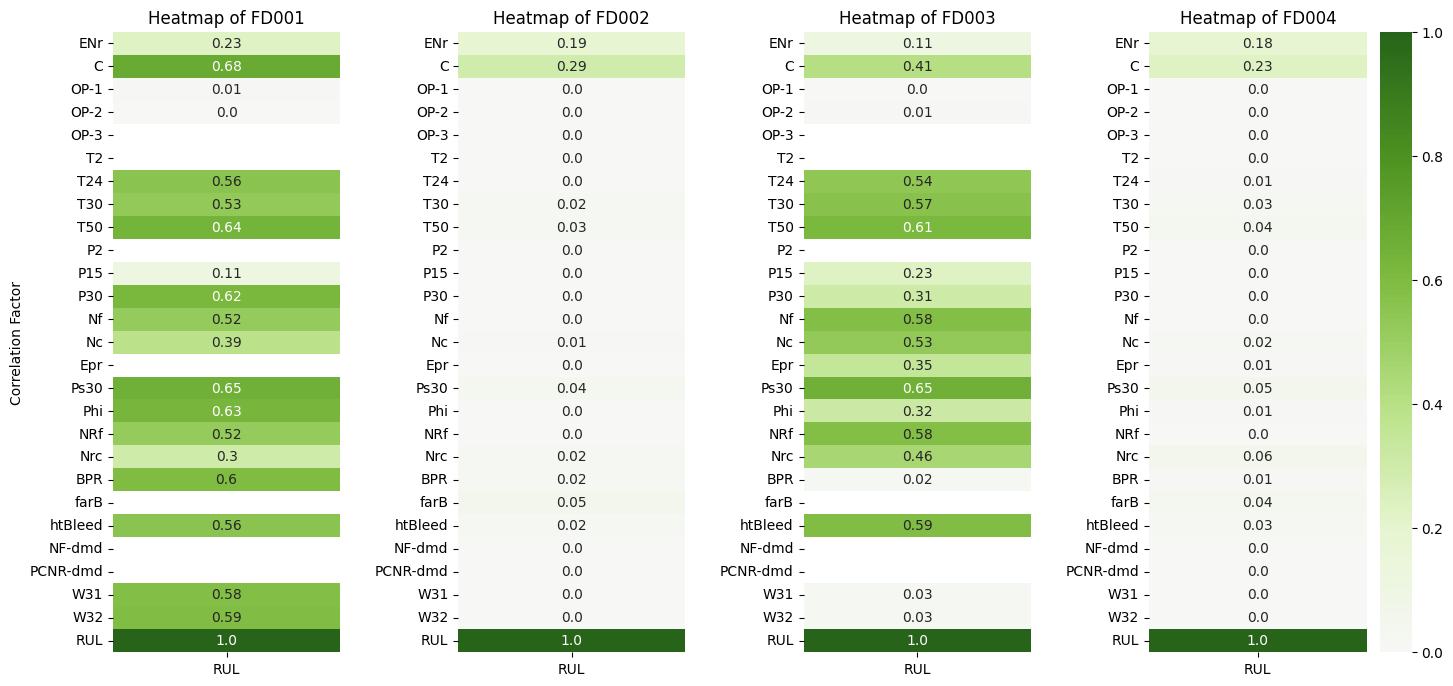

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

sns.heatmap(p1.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar=False)
axs[0].set_title('Heatmap of FD001')
axs[0].set_ylabel('Correlation Factor')

sns.heatmap(p2.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar=False)
axs[1].set_title('Heatmap of FD002')

sns.heatmap(p3.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar=False)
axs[2].set_title('Heatmap of FD003')

sns.heatmap(p4.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3])
axs[3].set_title('Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=2.5)

plt.show()


In [ ]:
def all_correlations(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')
  return round(correlation_matrix, 2)

In [ ]:
pear1=all_correlations(tr1)
pear2=all_correlations(tr2)
pear3=all_correlations(tr3)
pear4=all_correlations(tr4)

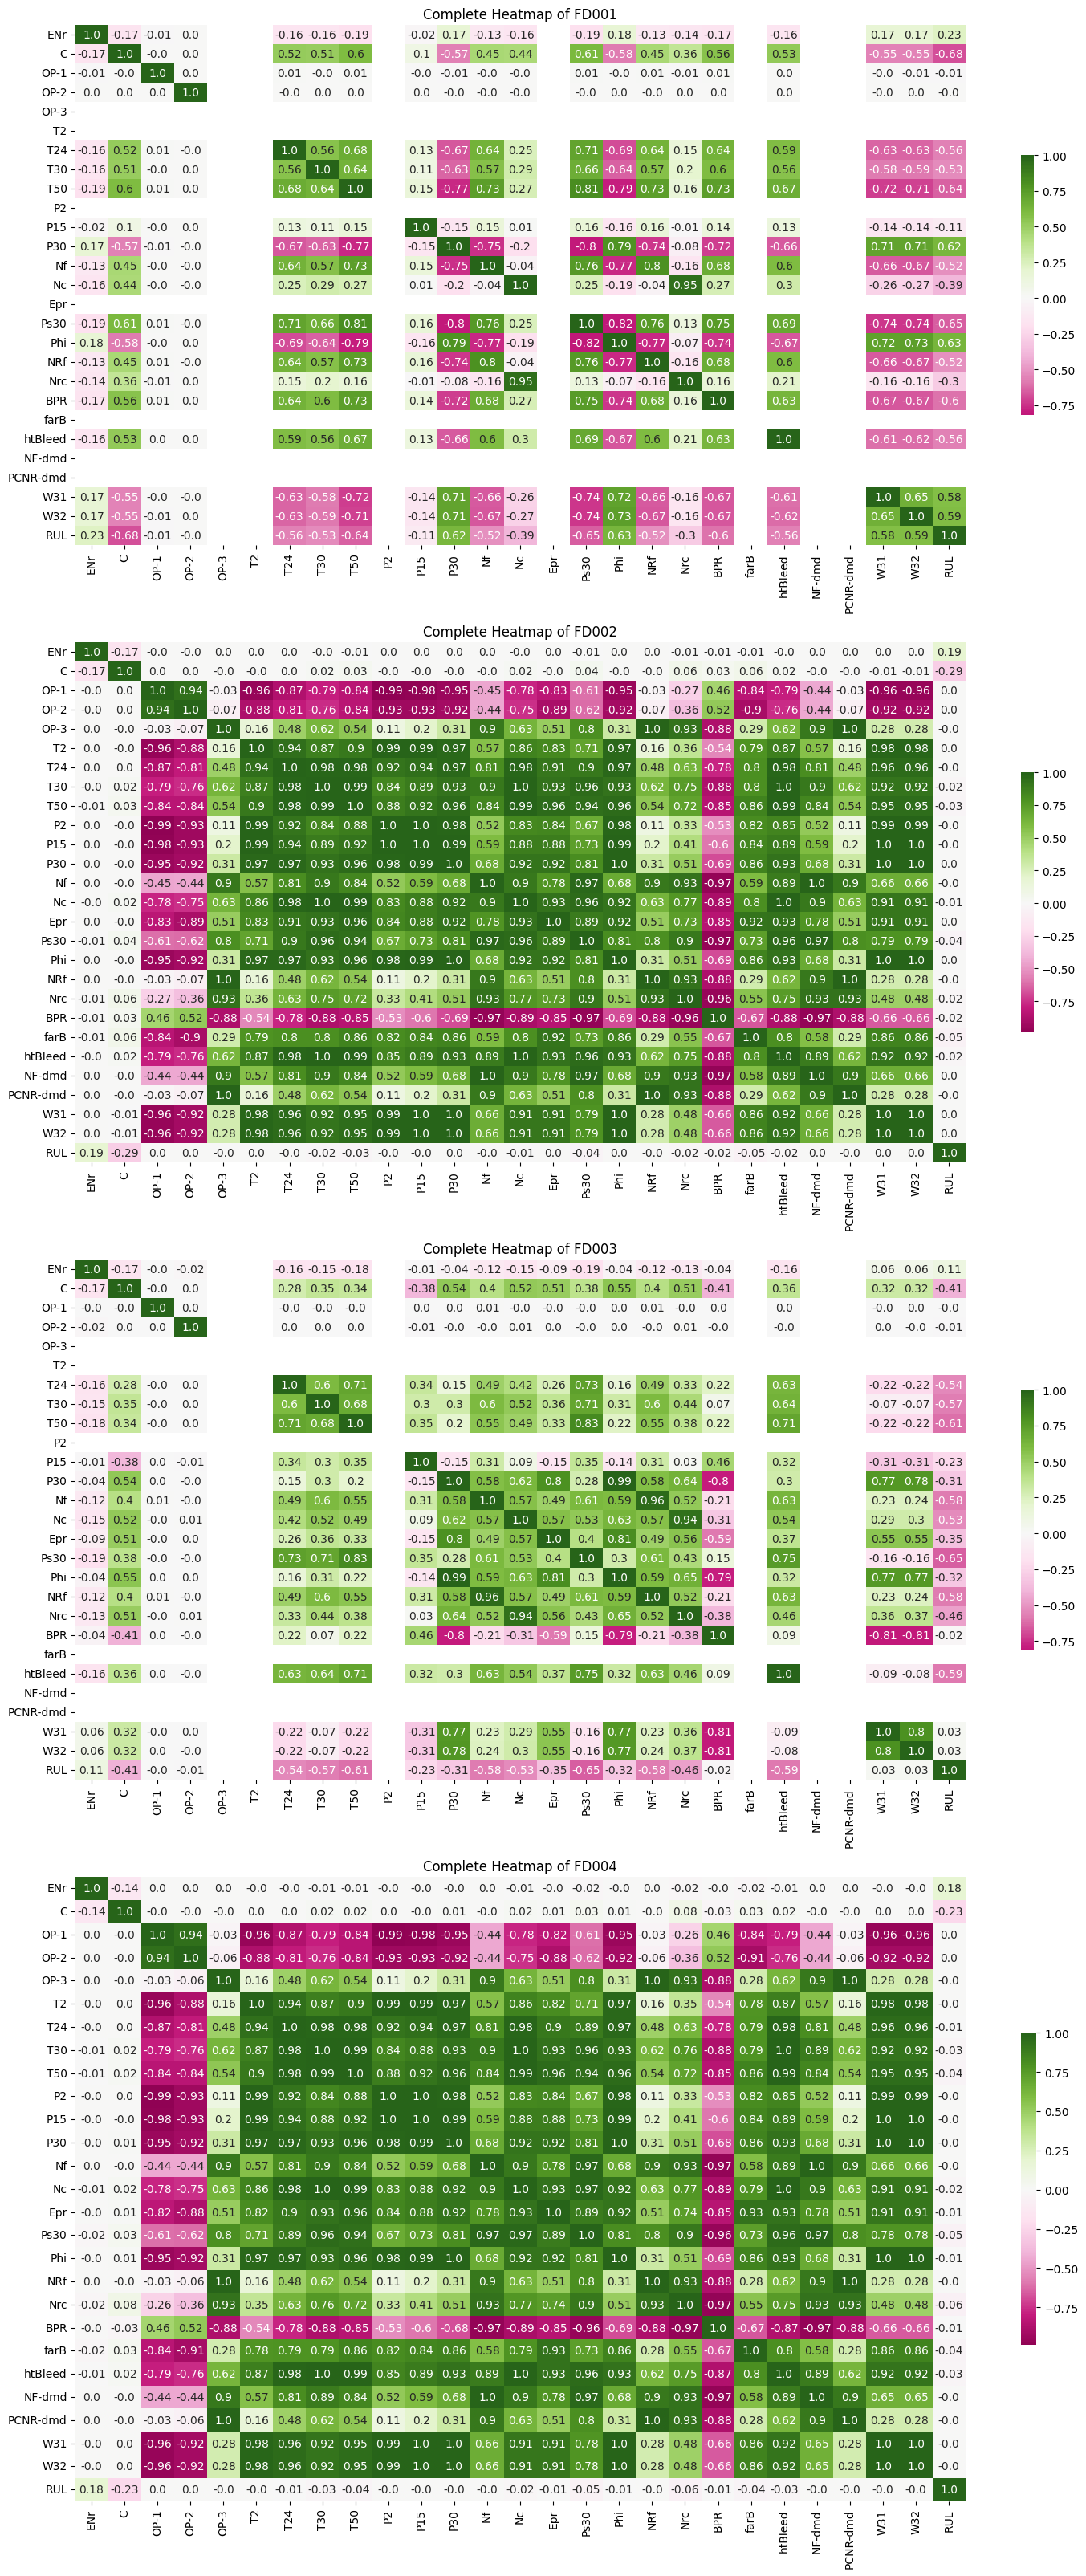

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 35), gridspec_kw={'height_ratios': [1, 1, 1, 1.2]})

sns.heatmap(pear1, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar_kws={"shrink": .5})
axs[0].set_title('Complete Heatmap of FD001')

sns.heatmap(pear2, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar_kws={"shrink": .5})
axs[1].set_title('Complete Heatmap of FD002')

sns.heatmap(pear3, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar_kws={"shrink": .5})
axs[2].set_title('Complete Heatmap of FD003')

sns.heatmap(pear4, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3], cbar_kws={"shrink": .5})
axs[3].set_title('Complete Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
sensor_pairs = []
for i, pear in enumerate([pear1, pear2, pear3, pear4], start=1):
    for sensor1, row in pear.iterrows():
        for sensor2, correlation in row.items():
            if correlation == 1 and sensor1 != sensor2:
                sensor_pairs.append((f'FD00{i}_{sensor1}', f'FD00{i}_{sensor2}'))

sensor_pairs_list= pd.DataFrame(sensor_pairs, columns=['Sensor1', 'Sensor2'])

In [ ]:
sensor_pairs_list

,Sensor1,Sensor2
0,FD002_OP-3,FD002_NRf
1,FD002_OP-3,FD002_PCNR-dmd
2,FD002_T30,FD002_Nc
3,FD002_T30,FD002_htBleed
4,FD002_P2,FD002_P15
...,...,...
59,FD004_W31,FD004_W32
60,FD004_W32,FD004_P15
61,FD004_W32,FD004_P30
62,FD004_W32,FD004_Phi


##Exclusions from each dataset based on correlation:
###Subset 1:
 OP-1, OP-2, OP-3, T2, P2, Epr, farB, NF-dmd, PCNR-dmd

###Subset 2:
OP-3, PCNR-dmd, NC, htBleed, P2, W31, W32, NF-dmd, P30,  

###Subset 3:
OP-1, OP-2, OP-3, T2, P2, BRP, farB, NF-dmd, PCNR-dmd, W31, W32

###Subset 4:
 9, 13, 16, 17, 21, 22, 23, 24, 25

#Neural Network Construction

#Implementing the performance measures

In [ ]:
#the asymmetric scoring function  - MASCHLER !!!
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [ ]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757
